# Get relative mutation count differences (compared to R1b1a2a1a2b)

In [1]:
import pandas as pd
import numpy as np
import pickle

import utils.VcfHandler as VcfHandler
import utils.BranchShortening as BranchShortening
import utils.YChrDataset as YChrDataset

rng = np.random.default_rng()

vcf_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))

res = BranchShortening.get_mutations_vs_individual(vcf_data, 'HGDP01075', YChrDataset.samples)
pickle.dump(res, open('data/output_data/ref_bias_analysis_mutation_diff.pkl', "wb"))

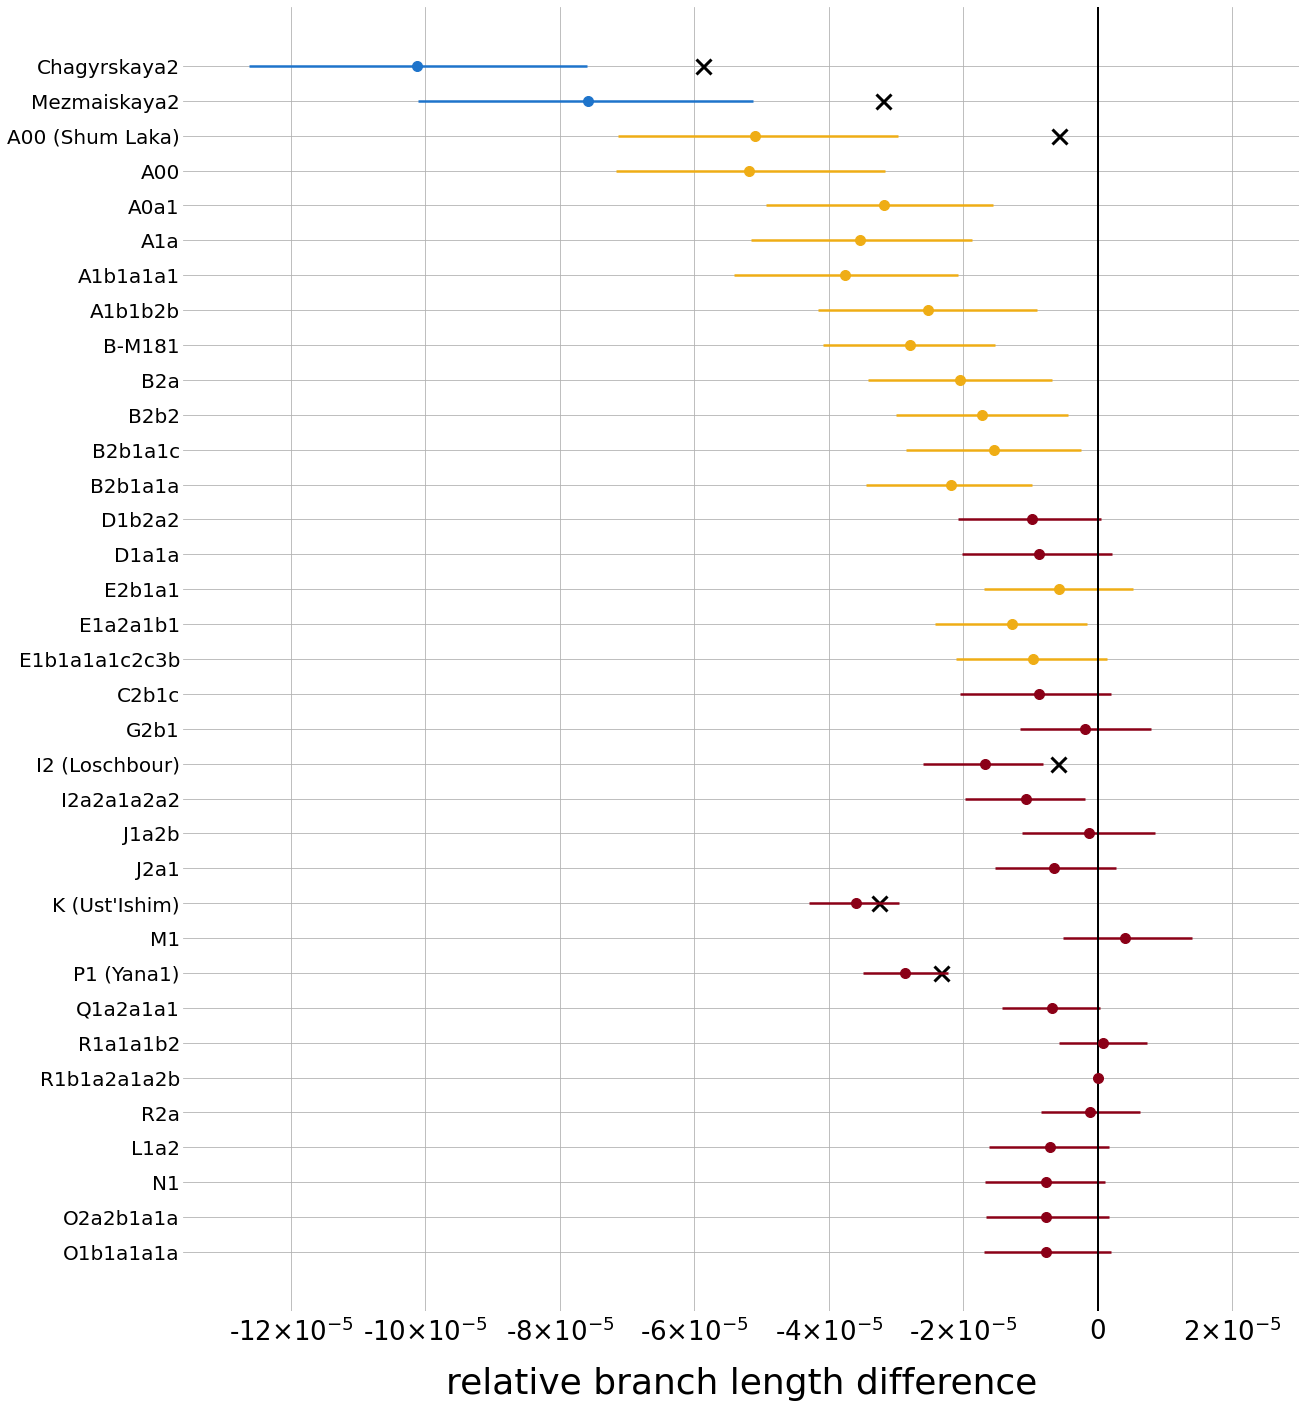

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import utils.YChrDataset as YChrDataset
from matplotlib.ticker import FuncFormatter

def formatter(x, lim):
    if np.round(x, 6) == 0:
        return 0
    else:
        x = str("%fe-5" % (1e5 * x,)).split("e")
        return (str(int(float(x[0]))) + r"$\times 10^{" + str(np.round(int(float(x[1])))) + r"}$")

mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()

samples = YChrDataset.samples
haplogroups = [YChrDataset.GetHaplogroup(x).split('\n', 1)[0] for x in samples]
pops = [YChrDataset.GetPop(x) for x in samples]

res = pickle.load(open('data/output_data/ref_bias_analysis_mutation_diff.pkl', 'rb'))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,24))

y_ticks = list(range(0, len(samples) * 2, 2))

pop_colors = {'African': '#EFAD15', 'non-African': '#8B0017', 'default': '#1E74CB'}
colours = [pop_colors.get(pop, pop_colors['default']) for pop in pops]
        
x = [i['normalised_diff'][0] for i in res.values()]
x_low = [x - i['normalised_diff'][1][0] for i, x in zip(res.values(), x)]
x_high = [i['normalised_diff'][1][1] - x for i, x in zip(res.values(), x)]

for i, y in enumerate(zip(y_ticks, samples)):
    pos = y[0]
    sample = y[1]
    if (sample in YChrDataset.ancient_samples):
        temp = 0 - (7.34e-10 * YChrDataset.GetAge(sample))
        ax.plot(temp, pos, ls='None', marker='x', color='k', markersize=15, markeredgewidth=3)
    ax.errorbar(x[i], pos, xerr=np.array([[x_low[i]], [x_high[i]]]), ls='None', marker='o', color=colours[i],  markersize=10, lw=2.5)
    
plt.axvline(0, lw=2, color='black')
plt.gca().invert_yaxis()

ax.set_yticks(y_ticks, haplogroups, ha='right', fontsize=20)
# ax.set_yticklabels([])
ax.xaxis.set_tick_params(labelsize=26, pad=7)
ax.set_xlabel('relative branch length difference', fontsize=36, labelpad=20)

ax.xaxis.set_major_formatter(FuncFormatter(formatter))
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlim([-13.6e-5, 3e-5])

ax.grid()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Determine the relationship between missing mutations and divergence from the reference (hg19) Y chromosome 

In [3]:
import pandas as pd
import numpy as np
import pickle

import utils.VcfHandler as VcfHandler
import utils.YChrDataset as YChrDataset

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()

vcf_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))

res = pickle.load(open('data/output_data/ref_bias_analysis_mutation_diff.pkl', 'rb'))

for sample in YChrDataset.samples:
    temp_df = vcf_data[['POS', 'REF', 'ALT', 'chimp', sample]].dropna(subset=['chimp', sample])
    divergence = len(temp_df[temp_df[sample] == 1]) / len(temp_df)
    res[sample]['divergence'] = divergence

pickle.dump(res, open('data/output_data/ref_bias_analysis_mutation_diff_with_divergence.pkl', "wb"))


Slope = -52.38942649622657 R = -0.9363555369004983 p = 8.585833744690972e-14 R_afr = -0.9163570044493143 p_afr = 1.07180279385162e-05


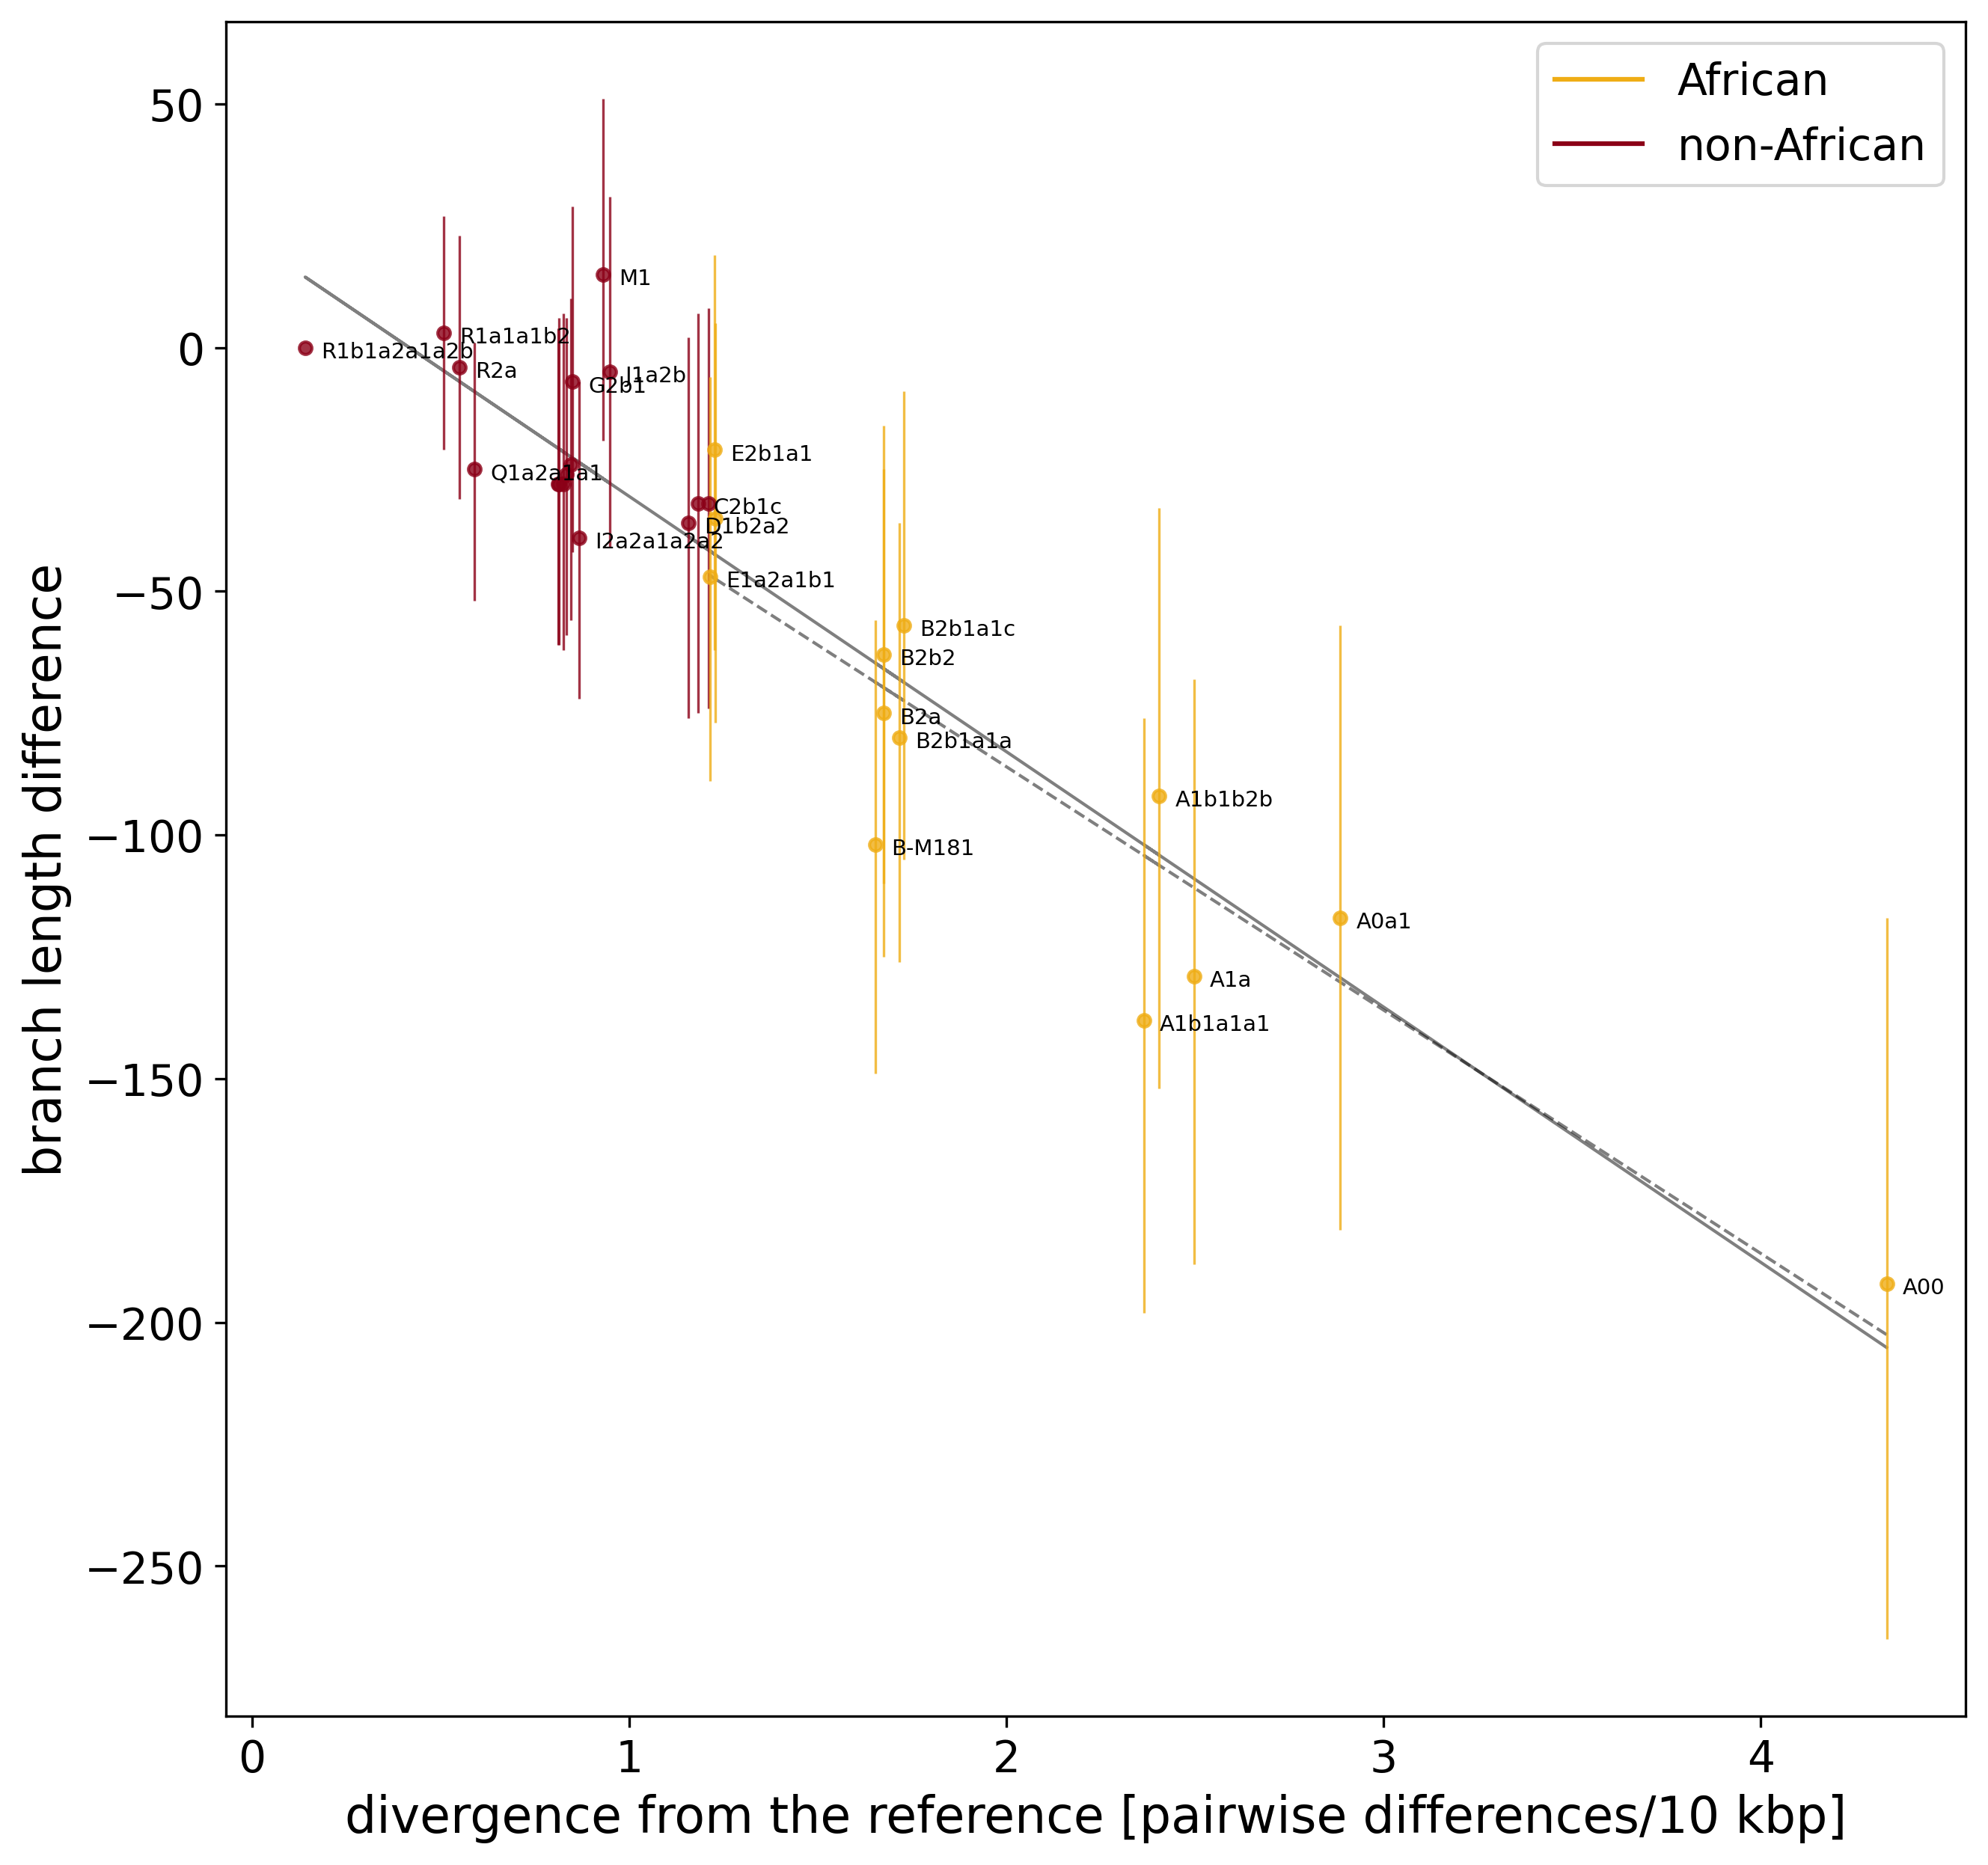

In [15]:
import matplotlib.pyplot as plt
import utils.YChrDataset as YChrDataset
import matplotlib as mpl
import pickle
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from scipy.stats import linregress

mpl.rcParams['figure.dpi'] = 300

res = pickle.load(open('data/output_data/ref_bias_analysis_mutation_diff_with_divergence.pkl', 'rb'))

samples = YChrDataset.samples
haplogroups = [YChrDataset.GetHaplogroup(x).split('\n', 1)[0] for x in samples if x not in YChrDataset.ancient_samples]
res = {k: v for k, v in res.items() if v['haplogroup'] in haplogroups}

# Prepare data for plotting
pops = [YChrDataset.GetPop(x) for x in samples if x not in YChrDataset.ancient_samples]
pop_colors = {'African': '#EFAD15', 'non-African': '#8B0017', 'default': '#1E74CB'}
colours = [pop_colors.get(pop, pop_colors['default']) for pop in pops]

mutation_diff = [i['mutation_diff'][0] for i in res.values()]
mutation_diff_low = [mutation_diff - i['mutation_diff'][1][0] for i, mutation_diff in zip(res.values(), mutation_diff)]
mutation_diff_high = [i['mutation_diff'][1][1] - mutation_diff for i, mutation_diff in zip(res.values(), mutation_diff)]
divergence = [i['divergence']*10000 for i in res.values()]

mutation_diff_afr = [i['mutation_diff'][0] for i in res.values() if ((('A' in i['haplogroup'])) or ('B' in i['haplogroup']) or ('E' in i['haplogroup']))]
divergence_afr = [i['divergence']*10000 for i in res.values() if ((('A' in i['haplogroup'])) or ('B' in i['haplogroup']) or ('E' in i['haplogroup']))]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

# Fit line to data
m, b = np.polyfit(divergence, mutation_diff, 1)
ax.plot(divergence, m*np.array(divergence) + b, color='k', lw=1, alpha=0.5)

m_afr, b_afr = np.polyfit(divergence_afr, mutation_diff_afr, 1)
ax.plot(divergence_afr, m_afr*np.array(divergence_afr) + b_afr, color='k', lw=1, alpha=0.5, linestyle='--')

slope, intercept, r_value, p_value, std_err = linregress(divergence, mutation_diff)

slope, intercept, r_value_afr, p_value_afr, std_err = linregress(divergence_afr, mutation_diff_afr)

# Annotate specific haplogroups
txt_haps = ['A00', 'A0a1', 'A1a', 'A1b1a1a1', 'A1b1b2b',
            'B-M181', 'B2a', 'B2b1a1c', 'B2b1a1a', 'B2b2',
            'C2b1c', 'D1b2a2',
            'E2b1a1','E1a2a1b1',
            'J1a2b', 'M1', 'G2b1', 'I2a2a1a2a2',
            'R1a1a1b2', 'R2a', 'R1b1a2a1a2b', 'Q1a2a1a1']

x_shift, y_shift = np.ptp(divergence) * 0.01, np.ptp(mutation_diff) * 0.01
for i, txt in enumerate(haplogroups):
    if txt in txt_haps:
        ax.text(divergence[i] + x_shift, mutation_diff[i] - y_shift, txt, fontsize=7)
    ax.errorbar(divergence[i], mutation_diff[i], yerr=np.array([[mutation_diff_low[i]], [mutation_diff_high[i]]]), ls='None', marker='o', color=colours[i], markersize=4, lw=0.8, alpha=0.8)

ax.set_xlabel('divergence from the reference [pairwise differences/10 kbp]', fontsize=16)
ax.set_ylabel('branch length difference', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.legend(
    loc="upper right",
    fontsize=14,
    handles = [
        Line2D([], [], c='#EFAD15', label='African'),
        Line2D([], [], c='#8B0017', label='non-African'),
    ]
)
    
print('Slope = ' + str(m), 'R = ' + str(r_value), 'p = ' + str(p_value), 'R_afr = ' + str(r_value_afr), 'p_afr = ' + str(p_value_afr))


# Calculate the mutation rates required to explain the shortened branches

In [11]:
import pandas as pd
import utils.BranchShortening as BranchShortening
import utils.VcfHandler as VcfHandler

vcf_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
vcf_data = vcf_data[['CHROM', 'POS', 'REF', 'ALT', 'chimp', 'HGDP01075', 'HGDP00931', 'HG02982', 'A00', 'Mezmaiskaya2']]

starting_mutation_rate = 7.34e-10

res1 = BranchShortening.get_missing_mutations(vcf_data, 'HGDP01075', 'HGDP00931', 0, 0, 7.34e-10)
res2 = BranchShortening.get_missing_mutations(vcf_data, 'HGDP00931', 'HG02982', 0, 0, res1['adjusted_mutation_rate'][0])
res3 = BranchShortening.get_missing_mutations(vcf_data, 'HG02982', 'A00', 0, 0, res2['adjusted_mutation_rate'][0])
res4 = BranchShortening.get_missing_mutations(vcf_data, 'A00', 'Mezmaiskaya2', 0, 43449, res3['adjusted_mutation_rate'][0])

res_df = pd.DataFrame([[starting_mutation_rate, 0],
                       [res1['adjusted_mutation_rate'][0], 1 - res1['adjusted_mutation_rate'][0]/starting_mutation_rate],
                       [res2['adjusted_mutation_rate'][0], 1 - res2['adjusted_mutation_rate'][0]/starting_mutation_rate],
                       [res3['adjusted_mutation_rate'][0], 1 - res3['adjusted_mutation_rate'][0]/starting_mutation_rate],
                       [res4['adjusted_mutation_rate'][0], 1 - res4['adjusted_mutation_rate'][0]/starting_mutation_rate],
                       ],
                       columns=['Mutation Rate', 'Proportional mutation rate difference'])

display(res_df)

res_df2 = pd.DataFrame([[starting_mutation_rate, 0],
                       [res1['adjusted_mutation_rate'][0], 1 - res1['adjusted_mutation_rate'][0]/starting_mutation_rate],
                       [res2['adjusted_mutation_rate'][0], 1 - res2['adjusted_mutation_rate'][0]/res1['adjusted_mutation_rate'][0]],
                       [res3['adjusted_mutation_rate'][0], 1 - res3['adjusted_mutation_rate'][0]/res2['adjusted_mutation_rate'][0]],
                       [res4['adjusted_mutation_rate'][0], 1 - res4['adjusted_mutation_rate'][0]/res3['adjusted_mutation_rate'][0]],
                       ],
                       columns=['Mutation Rate', 'Proportional mutation rate difference'])

display(res_df2)

,Mutation Rate,Proportional mutation rate difference
0,7.340000e-10,0.000000
1,5.138000e-10,0.300000
2,4.753170e-10,0.352429
3,4.312026e-10,0.412530
4,3.989028e-10,0.456536


0.840047277021908


,Mutation Rate,Proportional mutation rate difference
0,7.340000e-10,0.000000
1,5.138000e-10,0.300000
2,4.753170e-10,0.074899
3,4.312026e-10,0.092810
4,3.989028e-10,0.074906


# Estimate the percentage change in mutation rate caused by a change in generation time to 32 years

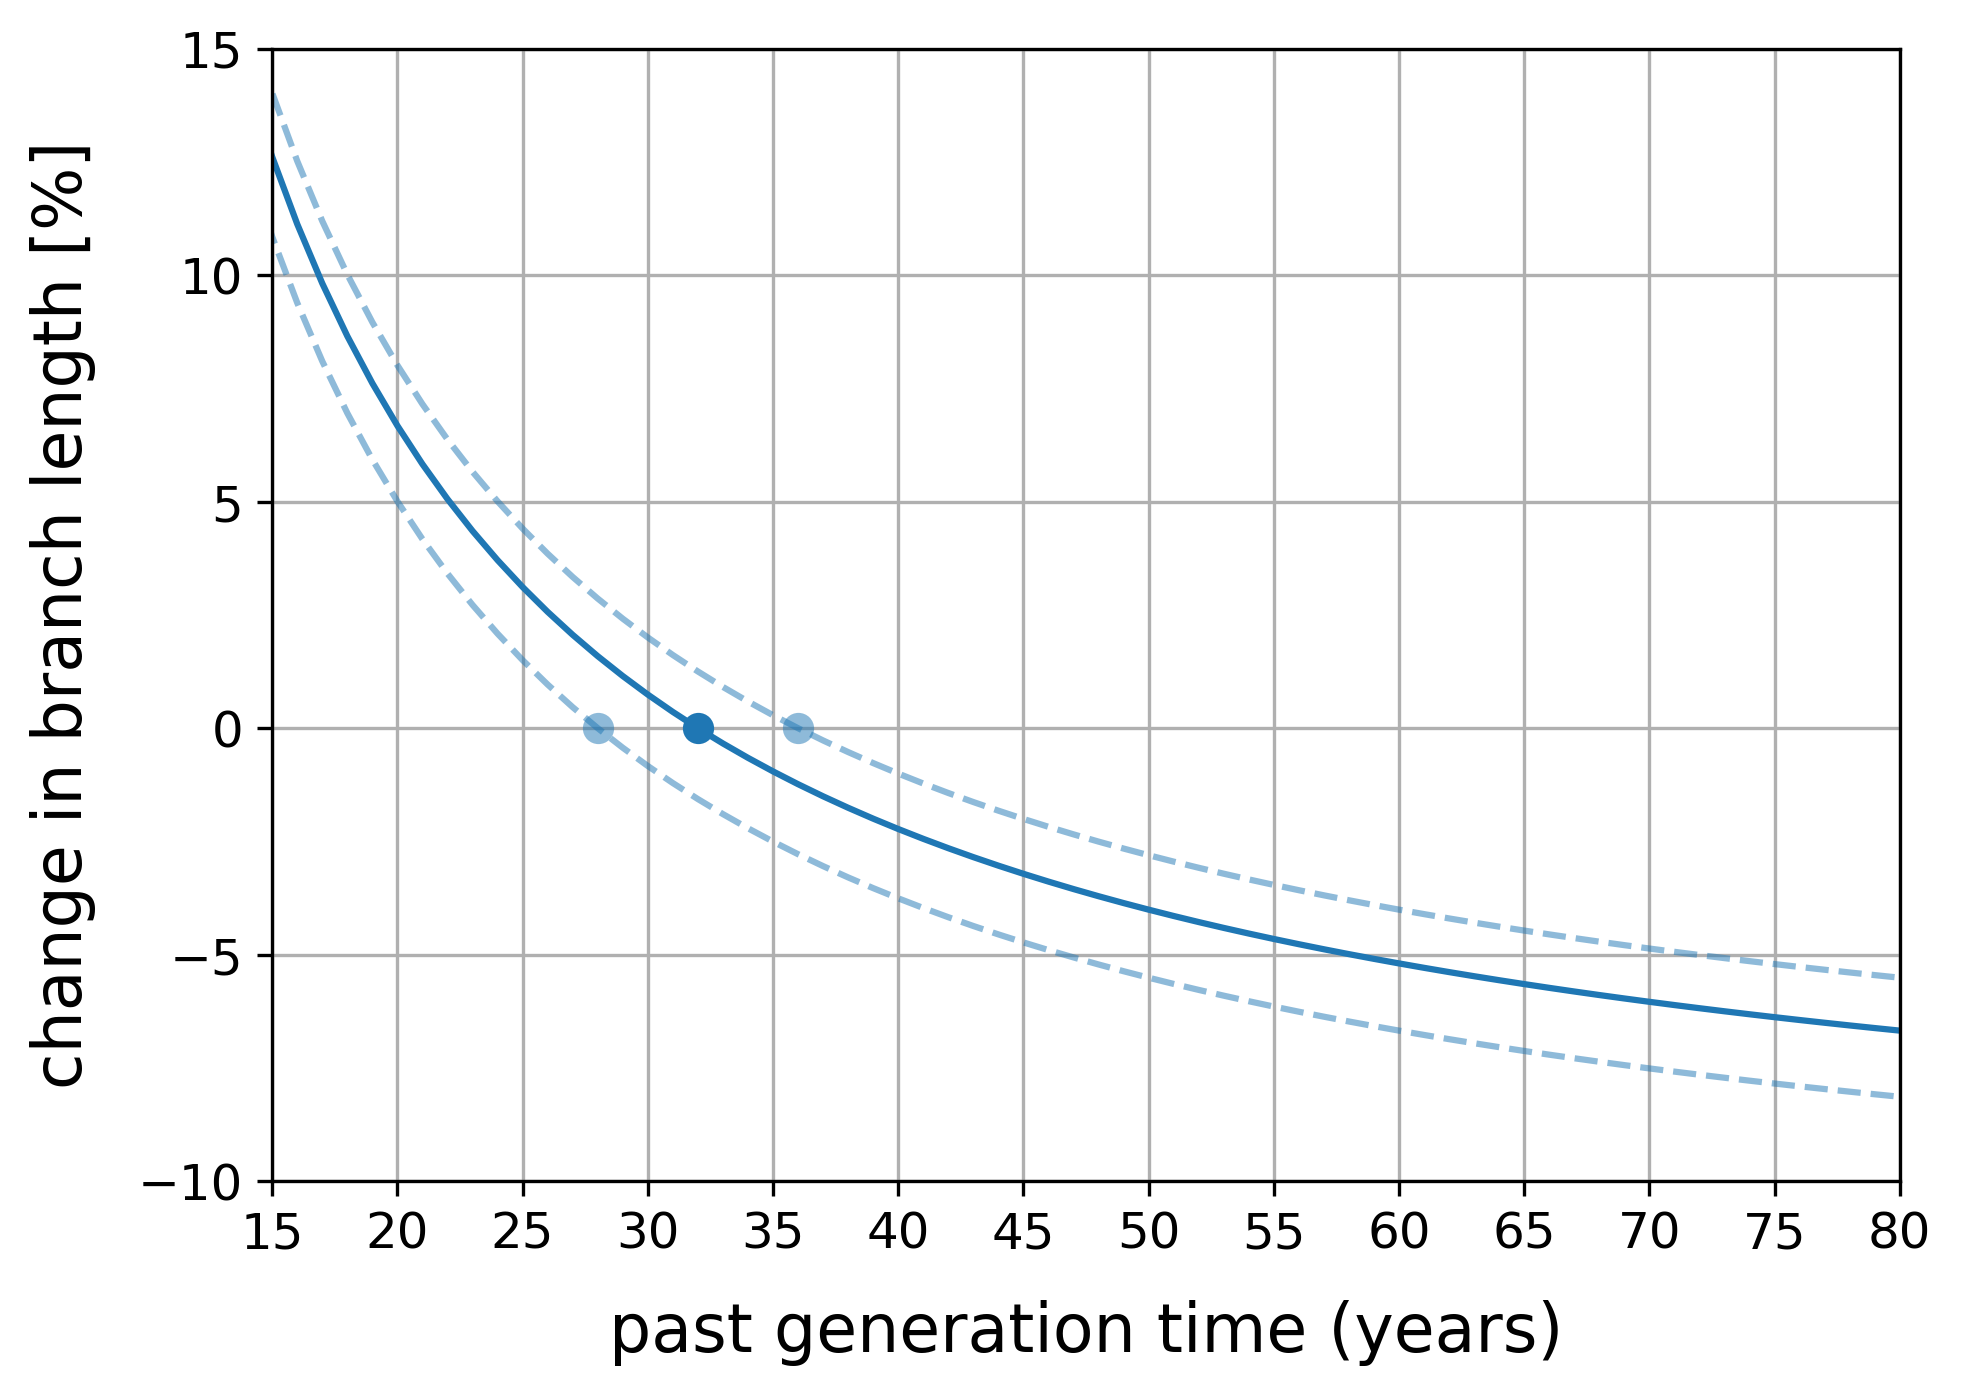

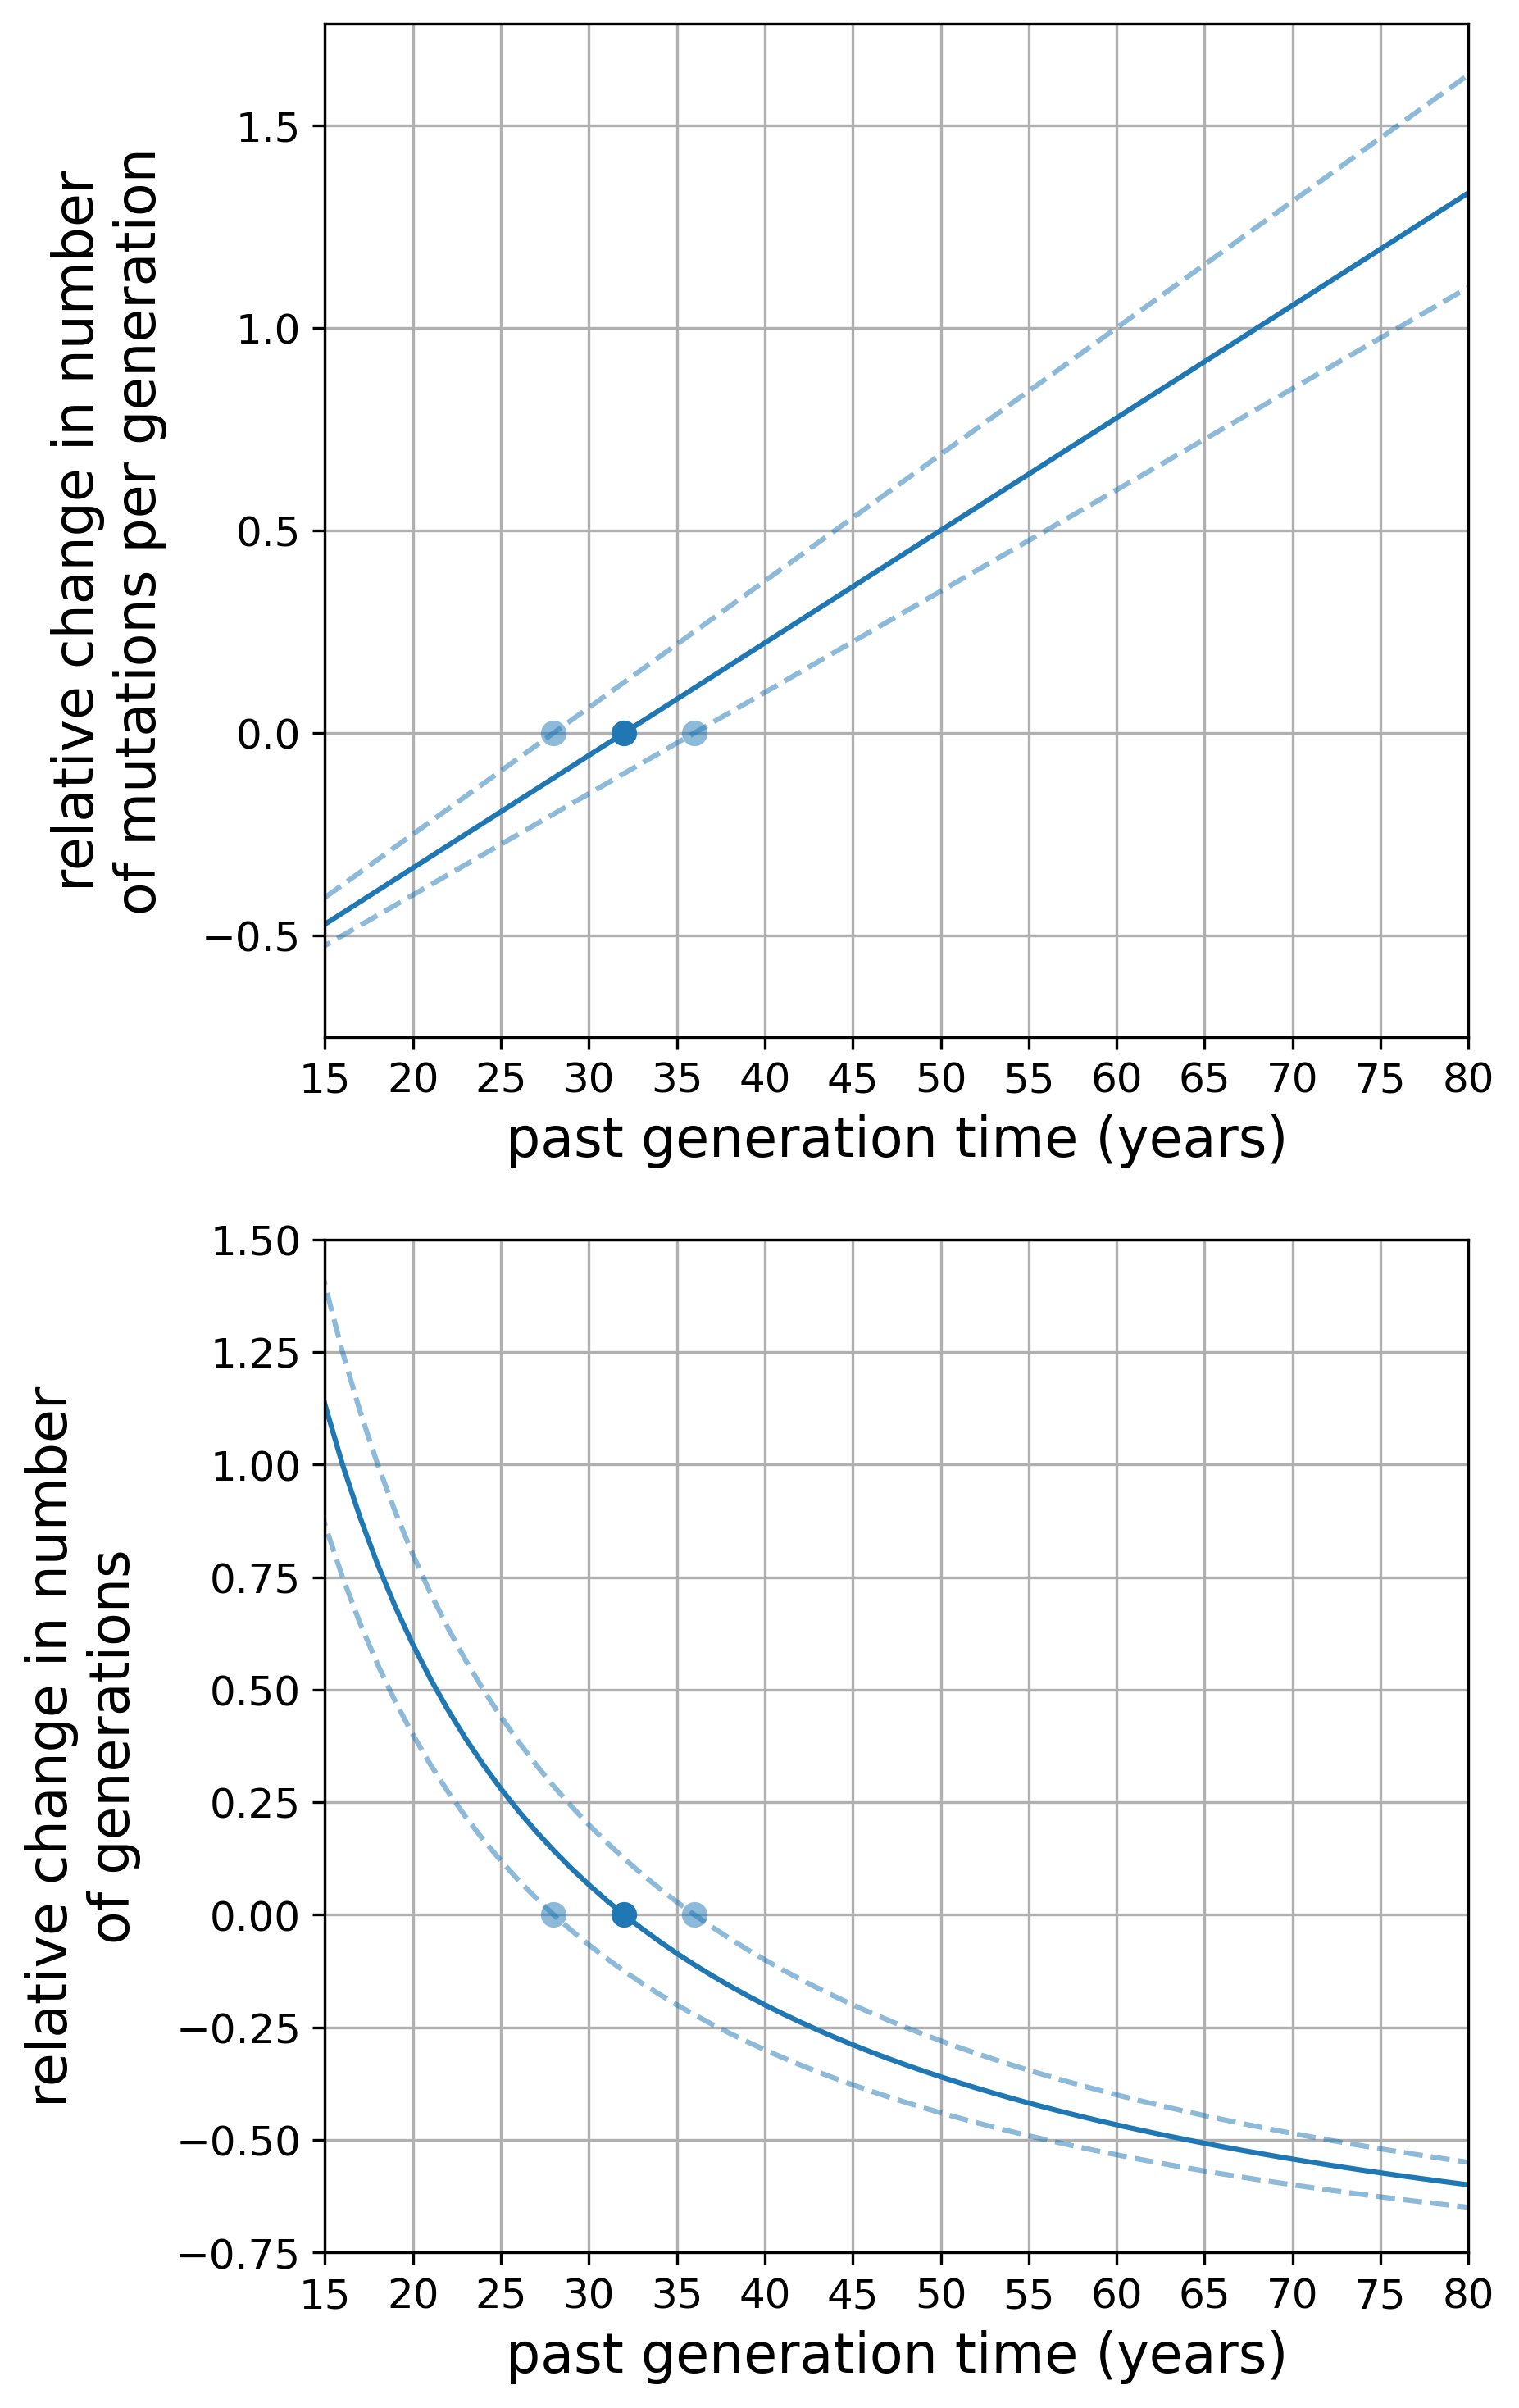

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

def mutation_rate(paternal_age):
    return (6.05 + 1.51 * paternal_age)

def mutation_rate_change(paternal_age, base_age):
    rate = mutation_rate(paternal_age)
    initial_rate = mutation_rate(base_age)
    
    # return (initial_rate - rate) / rate
    return (rate - initial_rate) / initial_rate

def gen_time_effect(paternal_age, base_age):
    # return (paternal_age - base_age) / base_age
    return (base_age - paternal_age) / paternal_age

def effective_mutation_rate(paternal_age, base_age):
    rate = mutation_rate(paternal_age)
    base_rate = mutation_rate(base_age)
    
    return 100 * ( (base_age / paternal_age) * rate - base_rate) / base_rate

gen_time = range(5, 100, 1)

mpl.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,5))

ax.plot(gen_time, [effective_mutation_rate(x, 32) for x in gen_time])
ax.plot(gen_time, [effective_mutation_rate(x, 28) for x in gen_time], color=colours[0], linestyle='--', alpha=0.5)
ax.plot(gen_time, [effective_mutation_rate(x, 36) for x in gen_time], color=colours[0], linestyle='--', alpha=0.5)

ax.set_ylabel('change in branch length [%]', fontsize=16, labelpad=10)
ax.set_xlabel('past generation time (years)', fontsize=16, labelpad=10)
ax.plot(32, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0)
ax.plot(28, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0, alpha=0.5)
ax.plot(36, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0, alpha=0.5)
ax.plot()
ax.set_xticks(range(5, 100, 5))
ax.set_xlim([15, 80])
ax.set_ylim([-10, 15])
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=12)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (6,12))

ax[0].plot(gen_time, [mutation_rate_change(x, 32) for x in gen_time])
ax[0].plot(gen_time, [mutation_rate_change(x, 28) for x in gen_time], color=colours[0], linestyle='--', alpha=0.5)
ax[0].plot(gen_time, [mutation_rate_change(x, 36) for x in gen_time], color=colours[0], linestyle='--', alpha=0.5)

ax[0].set_ylabel('relative change in number\nof mutations per generation', fontsize=16, labelpad=10)
ax[0].set_xlabel('past generation time (years)', fontsize=16, labelpad=4)
ax[0].plot(32, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0)
ax[0].plot(28, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0, alpha=0.5)
ax[0].plot(36, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0, alpha=0.5)
ax[0].set_xticks(range(5, 100, 5))
ax[0].set_xlim([15, 80])
ax[0].set_ylim([-0.75, 1.75])
ax[0].grid()
ax[0].tick_params(axis='both', which='major', labelsize=12)


ax[1].plot(gen_time, [gen_time_effect(x, 32) for x in gen_time])
ax[1].plot(gen_time, [gen_time_effect(x, 28) for x in gen_time], color=colours[0], linestyle='--', alpha=0.5)
ax[1].plot(gen_time, [gen_time_effect(x, 36) for x in gen_time], color=colours[0], linestyle='--', alpha=0.5)

ax[1].set_ylabel('relative change in number\nof generations', fontsize=16, labelpad=10)
ax[1].set_xlabel('past generation time (years)', fontsize=16, labelpad=4)
ax[1].plot(32, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0)
ax[1].plot(28, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0, alpha=0.5)
ax[1].plot(36, 0, ls='None', marker='.', color=colours[0], markersize=15, markeredgewidth=0, alpha=0.5)
ax[1].set_xticks(range(5, 100, 5))
ax[1].set_xlim([15, 80])
ax[1].set_ylim([-0.75, 1.5])
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=12)

# Get relative mutation count differences (compared to R1b1a2a1a2b) in the X-degenerate regions only

In [50]:
import pandas as pd
import numpy as np
import pickle

import utils.VcfHandler as VcfHandler
import utils.BranchShortening as BranchShortening
import utils.YChrDataset as YChrDataset

x_degen_regions = [
    ['Y', 2649374, 2917723],
    ['Y', 6616339, 7472224],
    ['Y', 14071703, 16095786],
    ['Y', 16170060, 17986473],
    ['Y', 18016663, 18271273],
    ['Y', 18537443, 19567356],
    ['Y', 21031901, 22216158],
    ['Y', 22512750, 23497632]]

x_degen_regions_df = pd.DataFrame(x_degen_regions)
rng = np.random.default_rng()

vcf_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
vcf_data = VcfHandler.filter_vcf(vcf_data, x_degen_regions_df)

res = BranchShortening.get_mutations_vs_individual(vcf_data, 'HGDP01075', YChrDataset.samples)
pickle.dump(res, open('data/output_data/ref_bias_analysis_mutation_diff_x_degen_regions.pkl', "wb"))


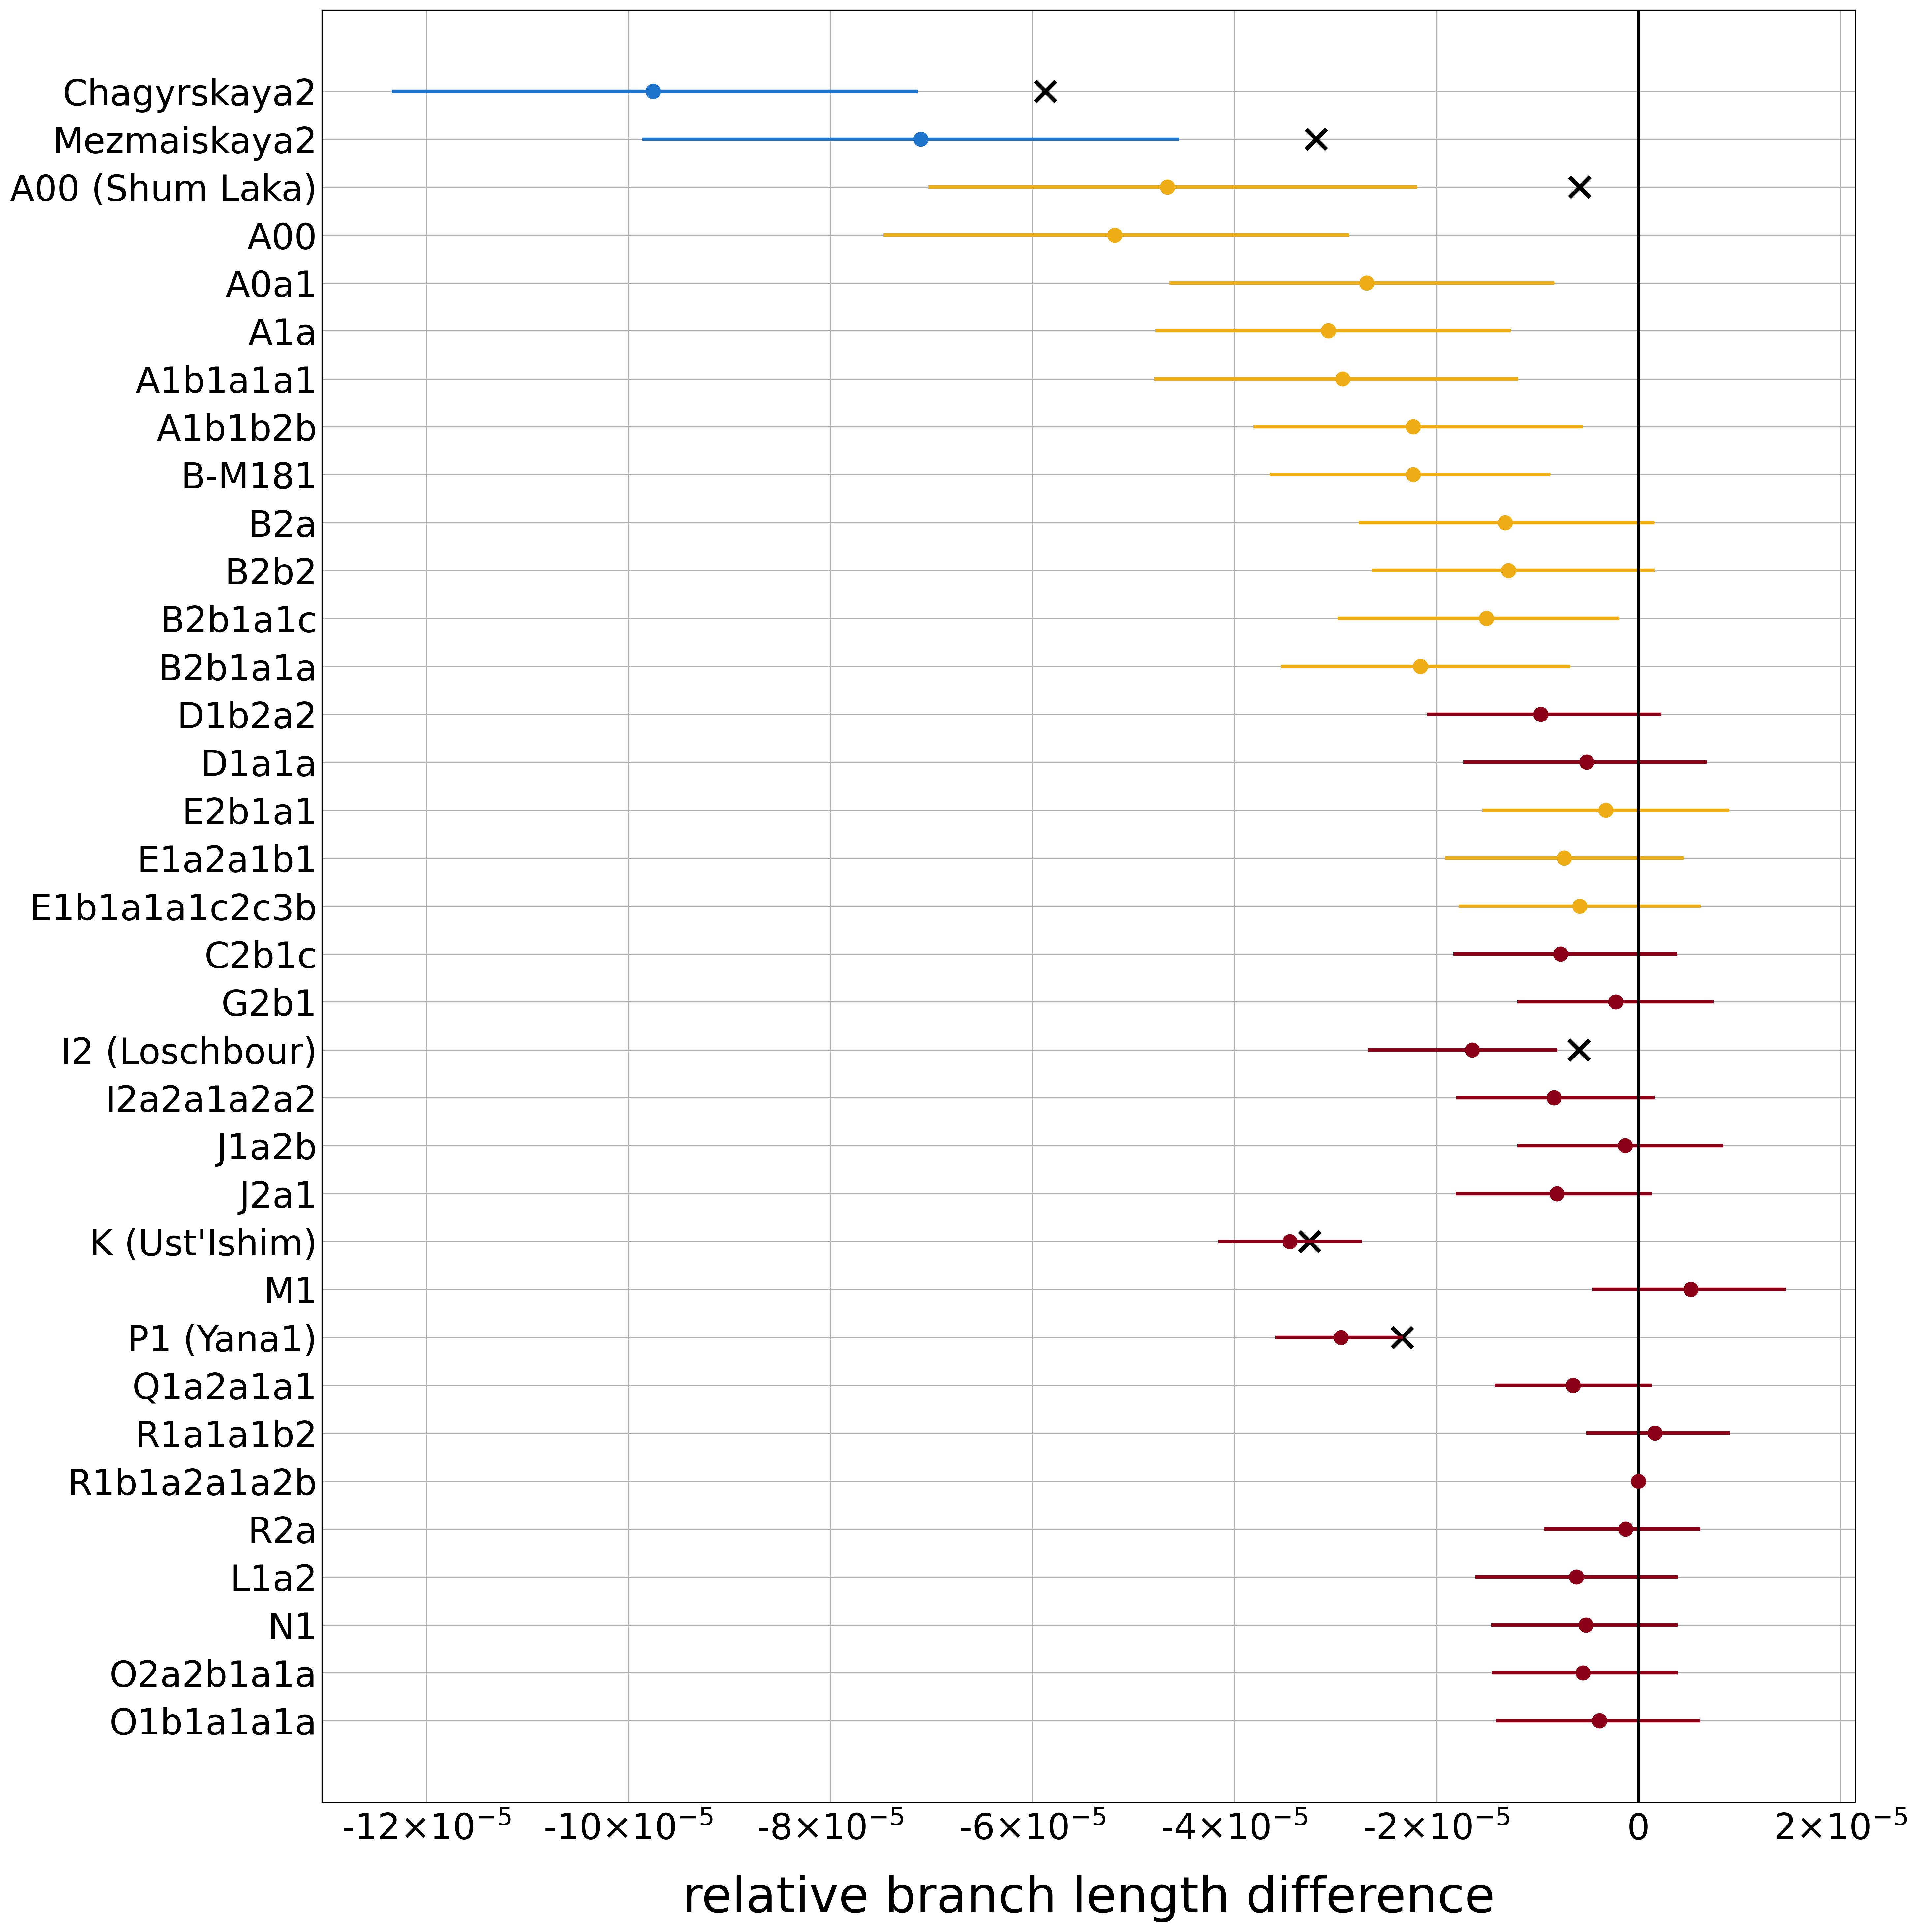

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle

import utils.YChrDataset as YChrDataset

from matplotlib.ticker import FuncFormatter

def formatter(x, lim):
    if np.round(x, 6) == 0:
        return 0
    else:
        x = str("%fe-5" % (1e5 * x,)).split("e")
        return (str(int(float(x[0]))) + r"$\times 10^{" + str(np.round(int(float(x[1])))) + r"}$")

mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()

# Load data
samples = YChrDataset.samples
haplogroups = [YChrDataset.GetHaplogroup(x).split('\n', 1)[0] for x in samples]
pops = [YChrDataset.GetPop(x) for x in samples]

res = pickle.load(open('data/output_data/ref_bias_analysis_mutation_diff_x_degen_regions.pkl', 'rb'))

# Prepare data for plotting
pop_colors = {'African': '#EFAD15', 'non-African': '#8B0017', 'default': '#1E74CB'}
colours = [pop_colors.get(pop, pop_colors['default']) for pop in pops]

x = [i['normalised_diff'][0] for i in res.values()]
x_low = [x - i['normalised_diff'][1][0] for i, x in zip(res.values(), x)]
x_high = [i['normalised_diff'][1][1] - x for i, x in zip(res.values(), x)]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,24))
y_ticks = list(range(0, len(samples) * 4, 4))
for i, y in enumerate(zip(y_ticks, samples)):
    pos = y[0]
    sample = y[1]
    if (sample in YChrDataset.ancient_samples):
        temp = 0 - (7.34e-10 * YChrDataset.GetAge(sample))
        ax.plot(temp, pos, ls='None', marker='x', color='k', markersize=15, markeredgewidth=3)
    ax.errorbar(x[i], pos, xerr=np.array([[x_low[i]], [x_high[i]]]), ls='None', marker='o', color=colours[i],  markersize=10, lw=2.5)
    
plt.axvline(0, lw=2, color='black')
plt.grid()
plt.gca().invert_yaxis()

ax.set_yticks(y_ticks, haplogroups, ha='right', fontsize=26)
ax.xaxis.set_tick_params(labelsize=26, pad=7)

ax.set_xlabel('relative branch length difference', fontsize=36, labelpad=20)

ax.xaxis.set_major_formatter(FuncFormatter(formatter))
ax.tick_params(axis='both', which='both', length=0)


# Get mutation count differences (compared to G2b1) for each reference

In [52]:
import pandas as pd
import numpy as np
import pickle

import utils.VcfHandler as VcfHandler
import utils.BranchShortening as BranchShortening
import utils.YChrDataset as YChrDataset

rng = np.random.default_rng()

# For the A0b and T2T Y chromosomes, remove the PAR regions, the centromere and the heterochromatic region of the q-arm as they are removed for hg19
a0b_region_filter = [['Y', 0, 2439226],
                     ['Y', 10267200, 13317839],
                     ['Y', 28526630, 46407904]]
a0b_region_filter_df = pd.DataFrame(a0b_region_filter)

t2t_region_filter = [['Y', 0, 2458320],
                     ['Y', 10565750, 12656463],
                     ['Y', 27449931, 62460029]]
t2t_region_filter_df = pd.DataFrame(t2t_region_filter)

samples = [sample for sample in YChrDataset.samples if (('A0b' in YChrDataset.GetReference(sample)) & ('T2T' in YChrDataset.GetReference(sample)))]
samples = [x for x in samples if (('A' in YChrDataset.GetHaplogroup(x)) or ('B' in YChrDataset.GetHaplogroup(x)) or ('D' in YChrDataset.GetHaplogroup(x)) or ('E' in YChrDataset.GetHaplogroup(x)) or ('J' in YChrDataset.GetHaplogroup(x)) or ('R' in YChrDataset.GetHaplogroup(x)))]
haplogroups = [YChrDataset.GetHaplogroup(x) for x in samples]
haplogroups = [x if x != 'A00 (Shum Laka)\n~8 kya' else 'A00 (Shum Laka)' for x in haplogroups]

vcf_data_hg19 = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))

vcf_data_a0b = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.A0b_mapped.vcf.gz.pkl'))
vcf_data_a0b = VcfHandler.filter_vcf(vcf_data_a0b, a0b_region_filter_df, True)

vcf_data_T2T = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.T2T_mapped.vcf.gz.pkl'))
vcf_data_T2T = VcfHandler.filter_vcf(vcf_data_T2T, t2t_region_filter_df, True)

res_hg19 = BranchShortening.get_mutations_vs_individual(vcf_data_hg19, 'HGDP00213', samples)
res_a0b = BranchShortening.get_mutations_vs_individual(vcf_data_a0b, 'HGDP00213', samples)
res_T2T = BranchShortening.get_mutations_vs_individual(vcf_data_T2T, 'HGDP00213', samples)

pickle.dump(res_hg19, open('data/output_data/ref_bias_analysis.hg19_mapped.pkl', "wb"))
pickle.dump(res_a0b, open('data/output_data/ref_bias_analysis.A0b_mapped.pkl', "wb"))
pickle.dump(res_T2T, open('data/output_data/ref_bias_analysis.T2T_mapped.pkl', "wb"))


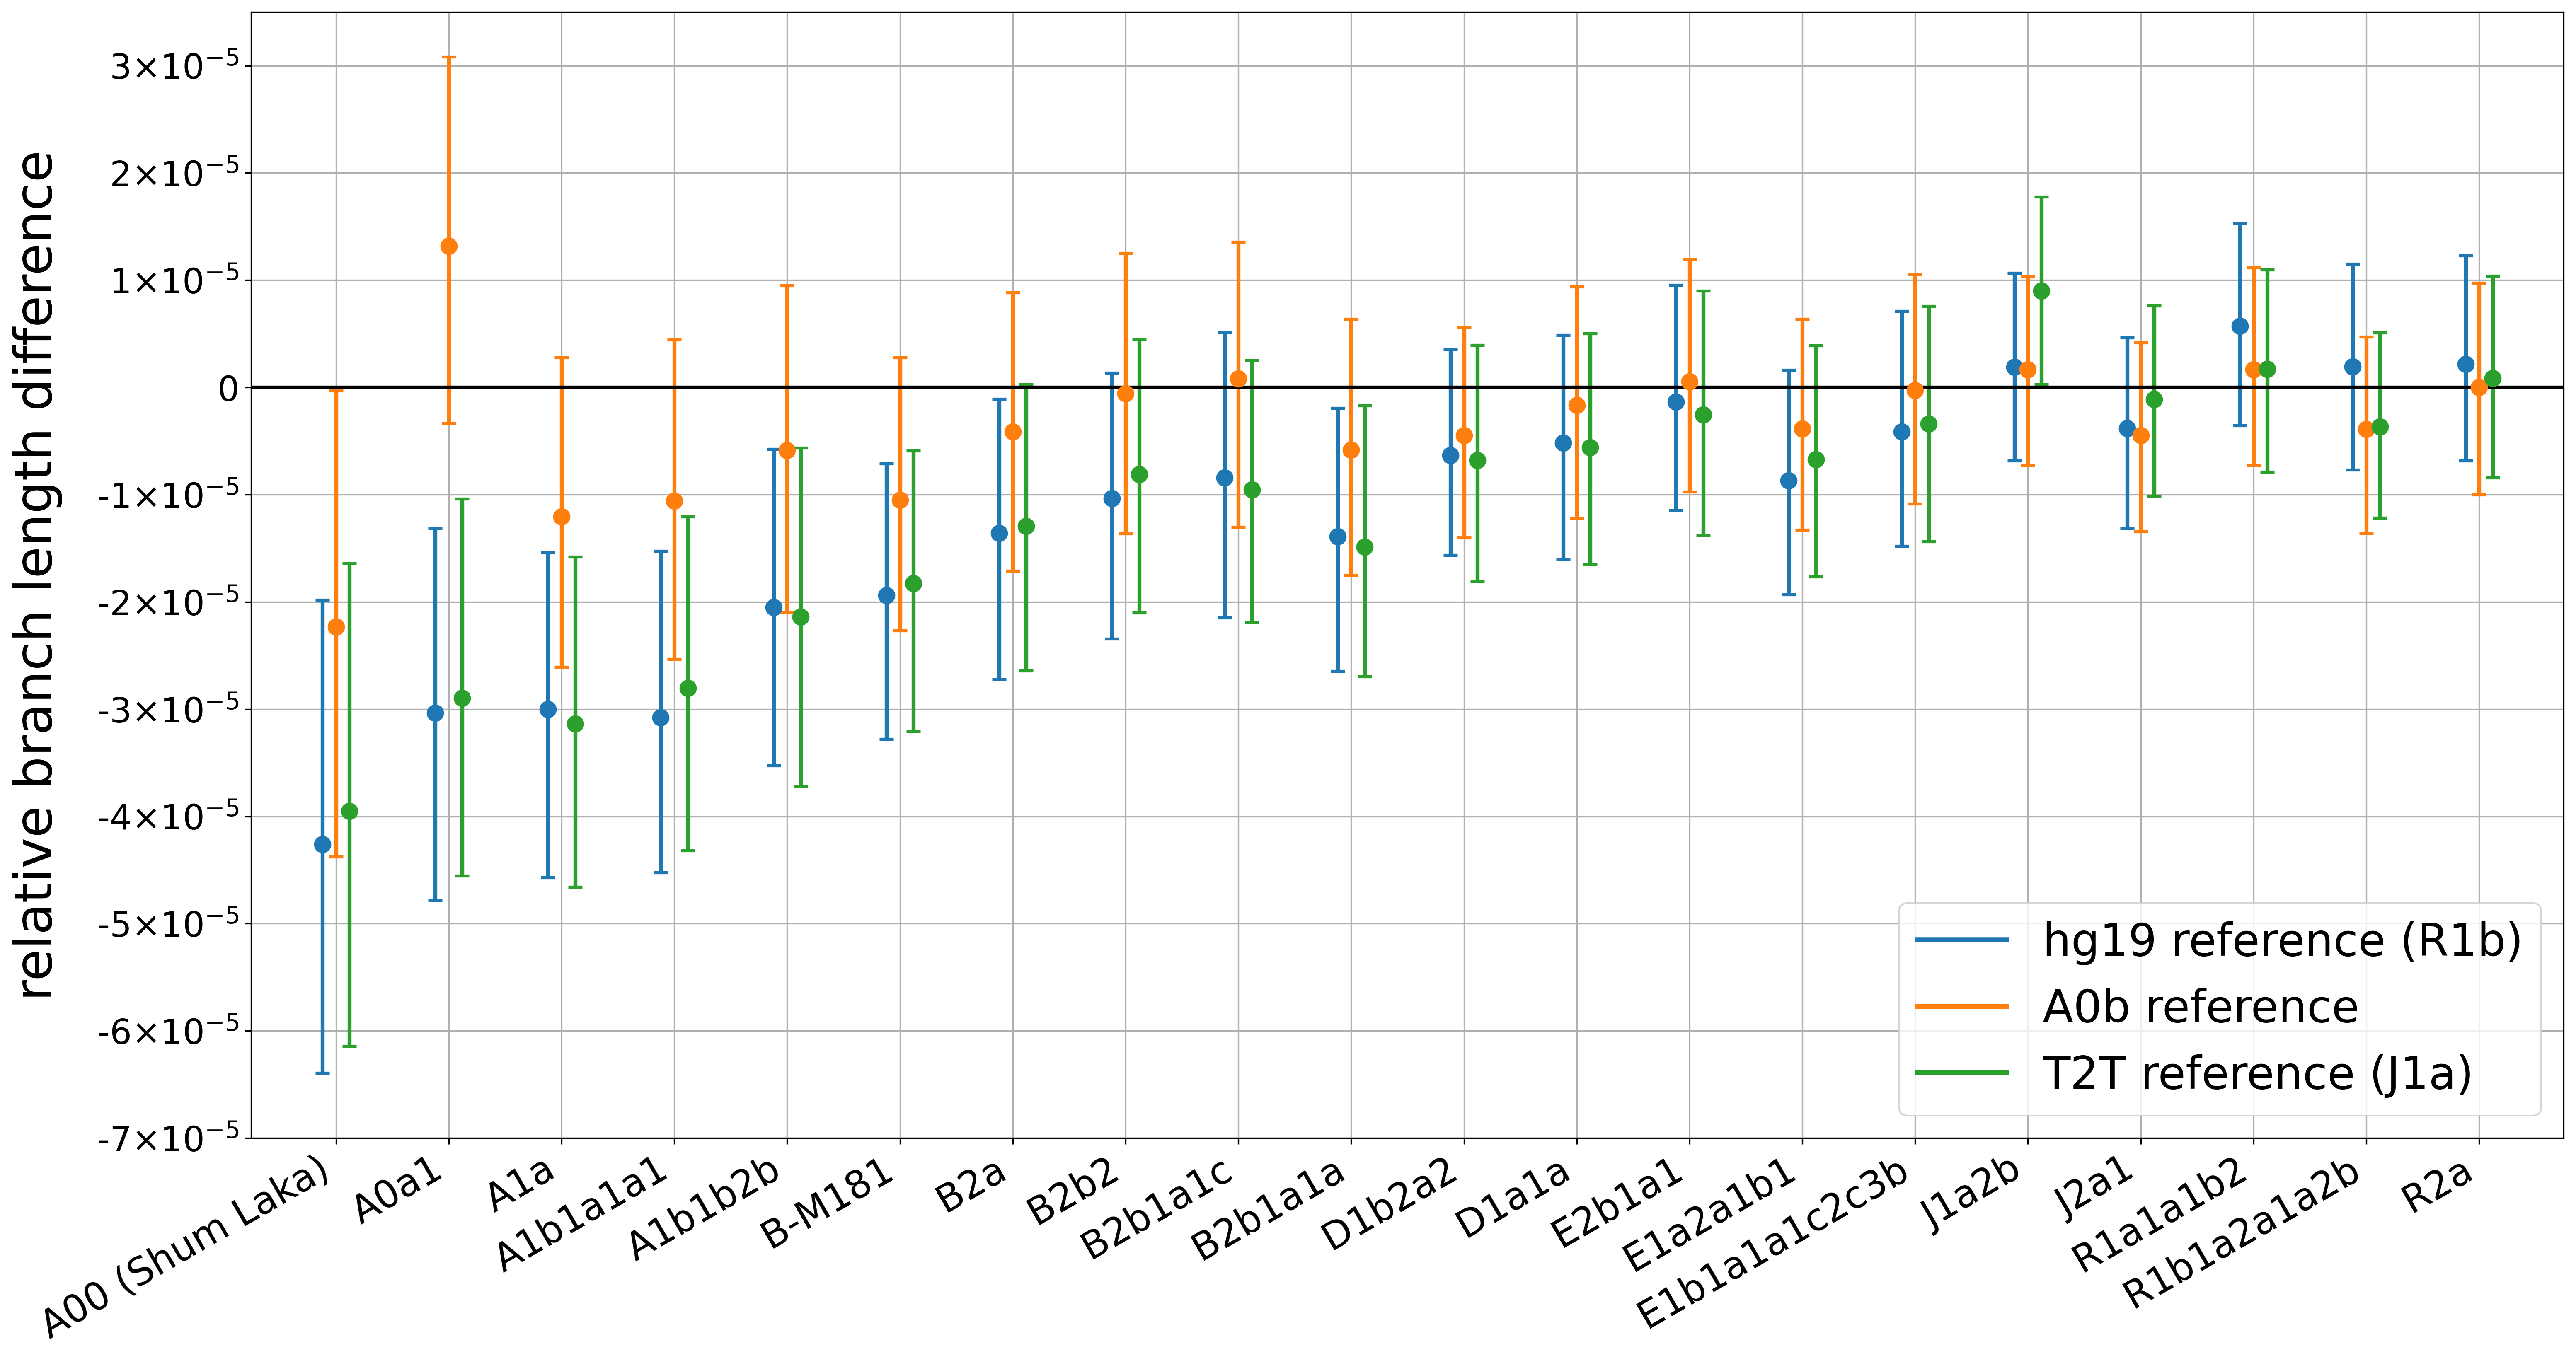

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import utils.YChrDataset as YChrDataset

import pickle
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D

mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()

def formatter(x, lim):
    if np.round(x, 6) == 0:
        return 0
    else:
        x = str("%fe-5" % (1e5 * x,)).split("e")
        return (str(int(float(x[0]))) + r"$\times 10^{" + str(np.round(int(float(x[1])))) + r"}$")

def prepare_data(res):
    y = [i['normalised_diff'][0] for i in res.values()]
    y_low = [y_val - i['normalised_diff'][1][0] for i, y_val in zip(res.values(), y)]
    y_high = [i['normalised_diff'][1][1] - y_val for i, y_val in zip(res.values(), y)]
    return y, y_low, y_high

def plot_error_bars(ax, x_labels, data, color, transform):
    y, y_low, y_high = data
    for i, x in enumerate(x_labels):
        ax.errorbar(x, y[i], yerr=np.array([[y_low[i]], [y_high[i]]]), ls='None', marker='o', color=color, markersize=9, lw=2.25, capsize=4, capthick=1.75, transform=transform)

res_hg19 = pickle.load(open('data/output_data/ref_bias_analysis.hg19_mapped.pkl', "rb"))
res_a0b = pickle.load(open('data/output_data/ref_bias_analysis.A0b_mapped.pkl', "rb"))
res_T2T = pickle.load(open('data/output_data/ref_bias_analysis.T2T_mapped.pkl', "rb"))

samples = [sample for sample in YChrDataset.samples if (('A0b' in YChrDataset.GetReference(sample)) & ('T2T' in YChrDataset.GetReference(sample)))]
samples = [x for x in samples if (('A' in YChrDataset.GetHaplogroup(x)) or ('B' in YChrDataset.GetHaplogroup(x)) or ('D' in YChrDataset.GetHaplogroup(x)) or ('E' in YChrDataset.GetHaplogroup(x)) or ('J' in YChrDataset.GetHaplogroup(x)) or ('R' in YChrDataset.GetHaplogroup(x)))]
haplogroups = [YChrDataset.GetHaplogroup(x) for x in samples]
haplogroups = [x if x != 'A00 (Shum Laka)\n~8 kya' else 'A00 (Shum Laka)' for x in haplogroups]

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
x_labels = list(range(0, len(samples)))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12))

trans = [Affine2D().translate(-0.12, 0.0) + ax.transData,
         Affine2D().translate(0, 0.0) + ax.transData,
         Affine2D().translate( +0.12, 0.0) + ax.transData]

plot_error_bars(ax, x_labels, prepare_data(res_hg19), colours[0], trans[0])
plot_error_bars(ax, x_labels, prepare_data(res_a0b), colours[1], trans[1])
plot_error_bars(ax, x_labels, prepare_data(res_T2T), colours[2], trans[2])

plt.axhline(0, lw=2, color='black')
plt.yticks(fontsize=20)
plt.grid()

ax.set_xticks(x_labels, haplogroups, rotation=30, ha='right', fontsize=22)
ax.set_yticks(np.linspace(-0.00007, 0.00003, num=11), fontsize=24)
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.set_ylabel('relative branch length difference', fontsize=30, labelpad=20)
ax.set_xlim([-0.75, len(samples) - 0.25])
ax.set_ylim([-0.00007, 0.000035])

plt.legend(
    loc="lower right",
    fontsize=26,
    handles=[
        Line2D([], [], c=colours[0], label="hg19 reference (R1b)", lw=3),
        Line2D([], [], c=colours[1], label='A0b reference', lw=3),
        Line2D([], [], c=colours[2], label='T2T reference (J1a)', lw=3),
    ]
)


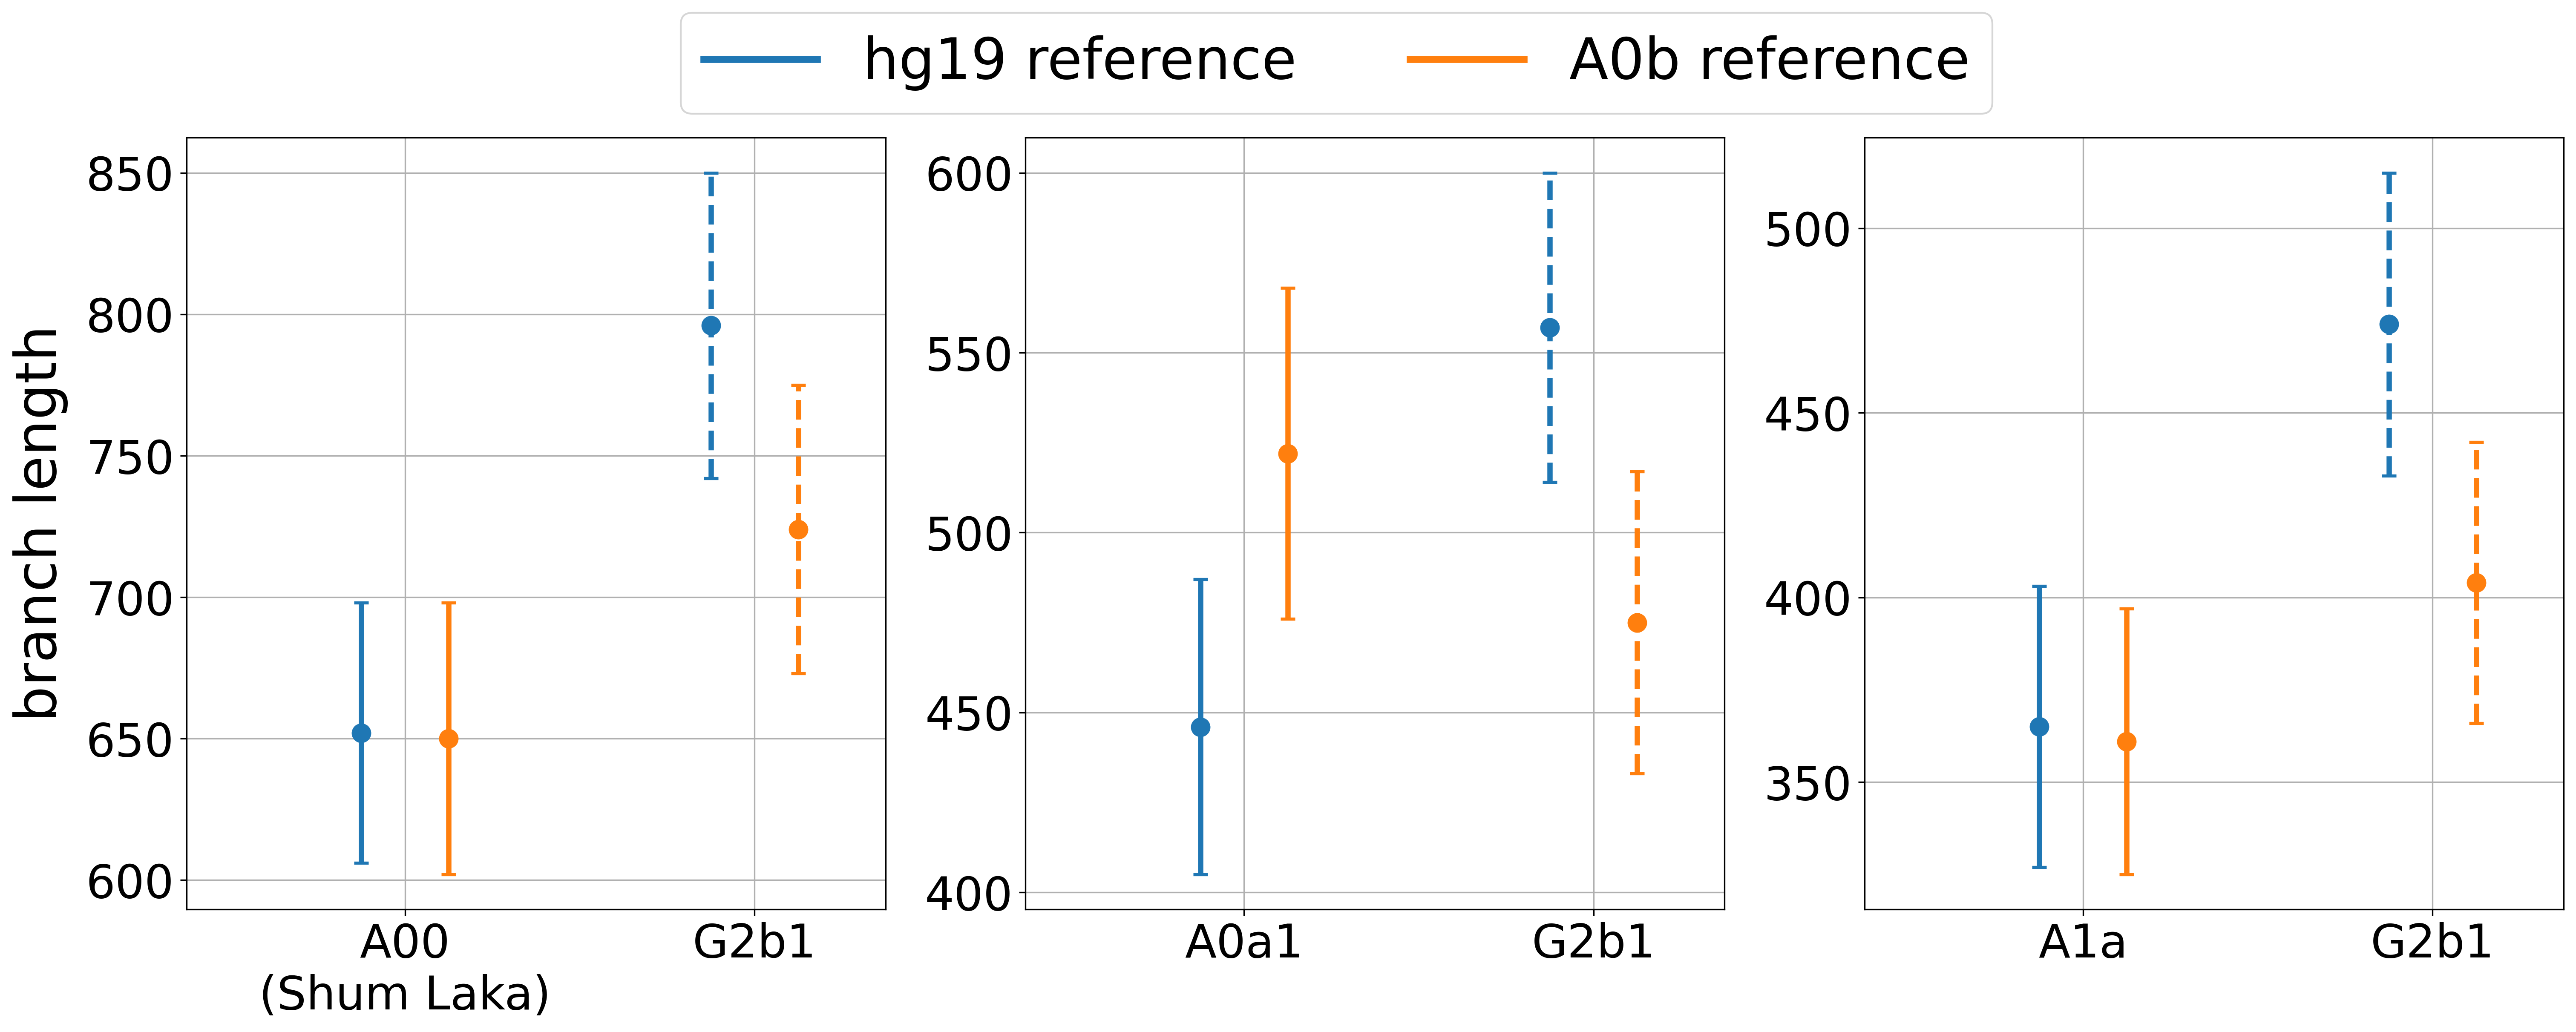

In [15]:
import matplotlib.pyplot as plt
import numpy as np

import pickle
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()

def get_data(res, key):
    return res[key]['derived_test_ind'], res[key]['derived_comp_ind']

def plot_error_bars(axis, data, colors, positions):
    for i, (pos, color) in enumerate(zip(positions, colors)):
        plot = axis.errorbar(pos, data[i][0], yerr=np.array(data[i][0] - data[i][1][0], data[i][1][1] - data[i][0]), marker='o', color=color, markersize=10, lw=3, capsize=4, capthick=1.75, ls='None')
        if i >= 2 != 0:
            plot[-1][0].set_linestyle('--')

def configure_axis(axis, xticks, labels):
    axis.set_xticks(xticks)
    axis.set_xticklabels(labels, fontsize=26)
    axis.tick_params(axis='both', which='major', labelsize=26)
    axis.grid()
    axis.set_xlim([-1, 7])

colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

# Load results
res_hg19 = pickle.load(open('data/output_data/ref_bias_analysis.hg19_mapped.pkl', "rb"))
res_a0b = pickle.load(open('data/output_data/ref_bias_analysis.A0b_mapped.pkl', "rb"))
res_T2T = pickle.load(open('data/output_data/ref_bias_analysis.T2T_mapped.pkl', "rb"))

# Plot data
samples = ['A00_I10871', 'HG02982', 'HG02666']
labels = [['A00\n(Shum Laka)', 'G2b1'], ['A0a1', 'G2b1'], ['A1a', 'G2b1']]
for i, sample in enumerate(samples):
    data_hg19 = get_data(res_hg19, sample)
    data_a0b = get_data(res_a0b, sample)
    plot_error_bars(ax[i], [data_hg19[0], data_a0b[0], data_hg19[1], data_a0b[1]], [colours[0], colours[1], colours[0], colours[1]], [1, 2, 5, 6])
    configure_axis(ax[i], [1.5, 5.5], labels[i])

ax[0].set_ylabel('branch length', fontsize=32, labelpad=10)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(fontsize=32, ncol=4,
    handles = [
        Line2D([], [], c=colours[0], label="hg19 reference", lw=4),
        Line2D([], [], c=colours[1], label='A0b reference', lw=4)
    ], labels = ["hg19 reference", 'A0b reference'], loc='upper center', bbox_to_anchor=(0.5, 1.03))